# Getting Started

In [1]:
from IPython.display import Image, Markdown, display

# import standard packages 
import pandas as pd
import numpy as np
import csv
import re

# set some parameters 
np.random.seed(47)
np.set_printoptions(4)
pd.options.display.max_rows = 20 
pd.options.display.max_columns = 15 
pd.set_option('precision', 2)



# Import standard plotting packages 
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns 

# Set some parameters 
plt.rcParams['figure.figsize'] = (12,9)
plt.rcParams['font.size'] = 12

from sklearn.linear_model import Ridge 





# Fetching the Data 

The Ames dataset consists of 2930 records taken from the Ames, Iowa, Assessor’s Office describing houses sold in Ames from 2006 to 2010. The data set has 23 nominal, 23 ordinal, 14 discrete, and 20 continuous variables (and 2 additional observation identifiers) --- 82 features in total.
The raw data are split into training and test sets with 1998 and 930 observations, respectively.

In [2]:
training_data = pd.read_csv("ames_train_cleaned.csv")
testing_data = pd.read_csv("ames_test_cleaned.csv")

In [3]:
training_data.columns.values


array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

In [4]:
testing_data.columns.values

array(['Order', 'PID', 'MS_SubClass', 'MS_Zoning', 'Lot_Frontage',
       'Lot_Area', 'Street', 'Alley', 'Lot_Shape', 'Land_Contour',
       'Utilities', 'Lot_Config', 'Land_Slope', 'Neighborhood',
       'Condition_1', 'Condition_2', 'Bldg_Type', 'House_Style',
       'Overall_Qual', 'Overall_Cond', 'Year_Built', 'Year_Remod/Add',
       'Roof_Style', 'Roof_Matl', 'Exterior_1st', 'Exterior_2nd',
       'Mas_Vnr_Type', 'Mas_Vnr_Area', 'Exter_Qual', 'Exter_Cond',
       'Foundation', 'Bsmt_Qual', 'Bsmt_Cond', 'Bsmt_Exposure',
       'BsmtFin_Type_1', 'BsmtFin_SF_1', 'BsmtFin_Type_2', 'BsmtFin_SF_2',
       'Bsmt_Unf_SF', 'Total_Bsmt_SF', 'Heating', 'Heating_QC',
       'Central_Air', 'Electrical', '1st_Flr_SF', '2nd_Flr_SF',
       'Low_Qual_Fin_SF', 'Gr_Liv_Area', 'Bsmt_Full_Bath',
       'Bsmt_Half_Bath', 'Full_Bath', 'Half_Bath', 'Bedroom_AbvGr',
       'Kitchen_AbvGr', 'Kitchen_Qual', 'TotRms_AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace_Qu', 'Garage_Type', 'Garage_Yr_Blt',

# Exploratory Data Analysis 

I first began to examin the raincloud plot (a combination of a histogram with density, a strip plot, and a box plot of our target variable of SalePrice. At the same time, I also took a look at some descriptive statistics of this variable)

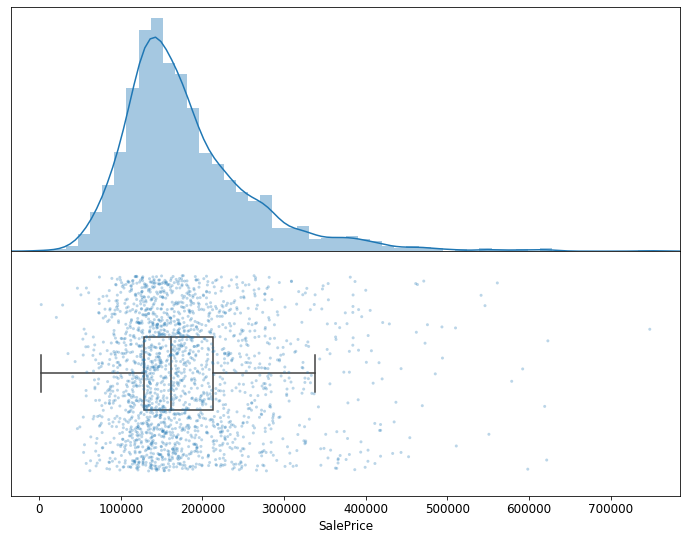

In [5]:
fig, axs = plt.subplots(nrows = 2)

sns. distplot(
    training_data['SalePrice'],
    ax = axs[0]
)

sns.stripplot(
    training_data['SalePrice'],
    jitter = 0.4, 
    size = 3,
    ax = axs[1],
    alpha = 0.3
)

sns.boxplot(
    training_data['SalePrice'], 
    width = 0.3,
    ax = axs[1],
    showfliers = False
)

#Align axes 
spacer = np.max(training_data["SalePrice"]) * 0.05
xmin = np.min(training_data["SalePrice"]) - spacer
xmax = np.max(training_data["SalePrice"]) + spacer
axs[0].set_xlim((xmin,xmax))
axs[1].set_xlim((xmin,xmax))

#Remove some axis text 
axs[0].xaxis.set_visible(False)
axs[0].yaxis.set_visible(False)
axs[1].yaxis.set_visible(False)


# Put the plots together 
plt.subplots_adjust(hspace = 0)

# Adjust boxplot fill to be white 
axs[1].artists[0].set_facecolor('white')

In [6]:
training_data['SalePrice'].describe()


count      1998.00
mean     180785.11
std       81619.69
min        2489.00
25%      128600.00
50%      162000.00
75%      213175.00
max      747800.00
Name: SalePrice, dtype: float64

From the graph and summary statistics above, we can understand: 
    1. The distribution of SalePrice in the training set is right skewed.
    2. The mean of the sale price is less than the median


# Feature Engineering 

Total Bathroom can be calculated as: 
    TotalBathrooms = (BsmtFullBath + Full Bath) + 1/2(BSMTHalfBath + HalfBath)
    
So I wrote a function add_total_bathrooms that return a copy of data with additional column called TotalBathrooms computed by the fomula above. 

To avoid error, I treated missing values as zeros. 

In [7]:
def add_total_bathrooms(data):
    
    """
    input: 
        data(data frame): a data frame containing at least 4 numeric columns 
        BSMT_Full_Bath, Full_Bath, BSMT_Half_Bath, and Half_Bath
    """
    with_bathrooms = data.copy()
    bath_vars = ["Bsmt_Full_Bath", "Full_Bath", "Bsmt_Half_Bath", "Half_Bath"]
    weights = pd.Series([1, 1, 0.5, 0.5], index = bath_vars)
    
    with_bathrooms = data.fillna({variable: 0 for variable in bath_vars})
    
    with_bathrooms['TotalBathrooms'] = with_bathrooms[bath_vars].dot(weights)
    
    return with_bathrooms 

training_data = add_total_bathrooms(training_data)

In [8]:
#Check that missing values are dealt with
assert not training_data['TotalBathrooms'].isnull().any()


I then used a boxplot to visualize the how TotalBathrooms is associated with SalePrice

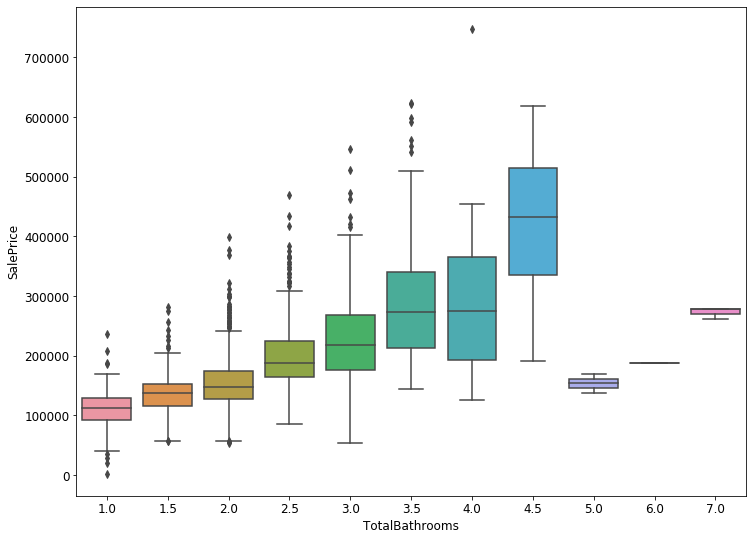

In [9]:
#Using a boxplot to show that TotalBathrooms is associated with SalePrice
sns.boxplot(x = training_data['TotalBathrooms'], y = training_data['SalePrice'])
plt.savefig('boxplot.png')

Then, I created some new features out of old features from data transformation

I frist visualized the association between SalePrice and Gr_Liv_Area. According to the codebook.txt file, Gr_Liv_Area measures the above ground living area square feet. This variable repsresnets the square footage of the house excluding anything underground. 

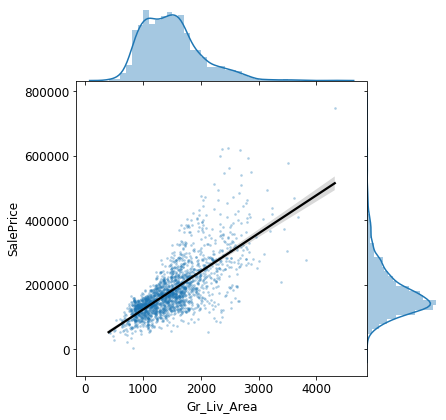

In [10]:
sns.jointplot(
    x = 'Gr_Liv_Area',
    y = 'SalePrice', 
    data = training_data,
    stat_func = None, 
    kind = 'reg',
    ratio = 4,
    space = 0,
    scatter_kws = {
        's': 3, 
        'alpha':0.25,
        
    },
    line_kws = {
        'color': 'black'
    }
    
);

Since Gr_Liv_Area excludes the garage space, I visualized the assocation between SalePrice and Garage_Area. The codebook/txt file states that Gr_Liv_Area measures "Size of garage in square feet"

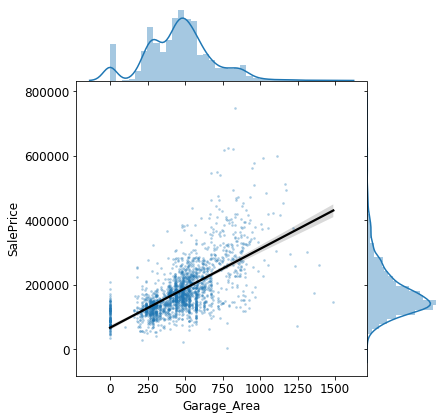

In [11]:
sns.jointplot(
    x = 'Garage_Area',
    y = 'SalePrice', 
    data = training_data,
    stat_func = None, 
    kind = 'reg',
    ratio = 4,
    space = 0,
    scatter_kws = {
        's': 3, 
        'alpha':0.25,
        
    },
    line_kws = {
        'color': 'black'
    }
    
);

In [12]:
def add_power(data, column_name, degree): 
    """"
    input:
    data(data frame): a data frame containing column called column_name
    column_name(string): a column in data 
    degree: positive integer
    
    output: 
    copy of data containing a column column_name2 with entries of column_name to power degree
    
    """
    with_power = data.copy()
    with_power[column_name + "2"] = data[column_name]** degree
    return with_power

training_data = add_power(training_data, 'Garage_Area', 2)
training_data = add_power(training_data, 'Gr_Liv_Area', 2)



In [13]:
corr_1 = training_data[['Gr_Liv_Area', 'SalePrice']].corr()
corr_2 = training_data[['Gr_Liv_Area2', 'SalePrice']].corr()
corr_3 = training_data[['Garage_Area', 'SalePrice']].corr()
corr_4 = training_data[['Garage_Area2', 'SalePrice']].corr()

In [14]:
print(corr_1, '\n', corr_2, '\n', corr_3,'\n', corr_4)

             Gr_Liv_Area  SalePrice
Gr_Liv_Area         1.00       0.72
SalePrice           0.72       1.00 
               Gr_Liv_Area2  SalePrice
Gr_Liv_Area2          1.00       0.71
SalePrice             0.71       1.00 
              Garage_Area  SalePrice
Garage_Area         1.00       0.65
SalePrice           0.65       1.00 
               Garage_Area2  SalePrice
Garage_Area2          1.00       0.64
SalePrice             0.64       1.00


Let's take a look at the relationship between neighborhood and sale prices of the houses in the data set. 

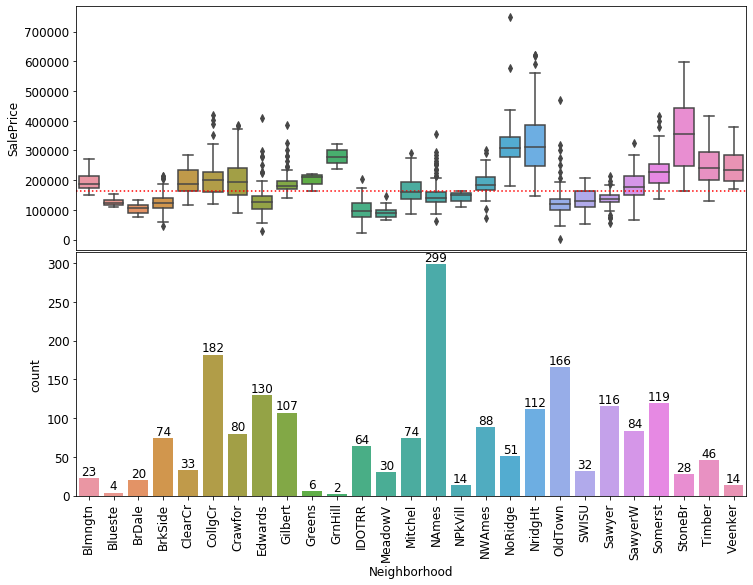

In [15]:
fig, axs = plt.subplots(nrows = 2)

sns.boxplot(
    x = 'Neighborhood',
    y= 'SalePrice',
    data = training_data.sort_values('Neighborhood'),
    ax = axs[0]

)

sns.countplot(
    x = 'Neighborhood',
    data = training_data.sort_values('Neighborhood'),
    ax = axs[1]
)

#Draw median price 
axs[0].axhline(
    y = training_data['SalePrice'].median(),
    color = 'red',
    linestyle = 'dotted'
)

#Label the bars with counts
for patch in axs[1].patches:
    x = patch.get_bbox().get_points()[:, 0]
    y = patch.get_bbox().get_points()[1, 1]
    axs[1].annotate(f'{int(y)}', (x.mean(),y), ha = 'center', va = 'bottom')
                    
#Format x-axes 
axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(),rotation = 90)
axs[0].xaxis.set_visible(False)

#Narrow the gap between the plots 
plt.subplots_adjust(hspace = 0.01)

            

I found a lot of variation in prices across neighborhoods. Moreover, the amount of data available is not uniformly distributed amound neighborhoods. For example, North Ames, comprises almost 15% of the training data while Green Hill has only 2 observations in this data set. 

The way I dealt with the lack of data from some neighborhoods was to create a new feature that bins neighborhoods together. I categorized the neighborhoods in a crude way: I took the top 3 neighborhoods measured by the median SalePrice and identify them as "rich neighborhoods", the other neighborhoods are not marked. 

In [16]:
def find_rich_neighborhoods(data, n= 3, metric = np.median):
    """
    input: 
        data(data frame): should contain at least a string-valued Neighborhoods
        and a numeric SalePrice column
        n(int): the number of top valued desired 
        mertric(function): function used for aggregating the data in each 
        neighborhood. 
        for example, np.median for median prices 
    output: 
        a list of top n riches neighborhoods as measured by the metric function
    """
    
    copy = data.copy()
    sorted_data = copy.groupby('Neighborhood', as_index = False).aggregate(metric).sort_values(by = 'SalePrice', ascending = False)
    neighborhoods = sorted_data['Neighborhood'][0:n].to_list()
    return neighborhoods

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
rich_neighborhoods

['StoneBr', 'NridgHt', 'NoRidge']

I now have a list of neighborhoods that are deemed as richer than others. I used that information to make a new variable in_rich_neighborhood. 

I wrote a function add_rich_neighborhood that adds an indicator variable which takes on the value 1 if the house is part of rich_neighborhoods and the value 9 otherwise. 

In [17]:
def add_in_rich_neighborhood(data, neighborhoods):
    """"
    Input: 
        data(data frame): a data frame containing a 'Neighborhood' column with 
        values found in the codebook
        neighborhoods(list of strings): strings should be the names of the neighborhoods
    Output: 
        data frame identical to the input with the addition of a binary in _rich_neighborhood column 
    """
    data['in_rich_neighborhood'] = data['Neighborhood'].isin(rich_neighborhoods) *1 
    return data 

rich_neighborhoods = find_rich_neighborhoods(training_data, 3, np.median)
training_data = add_in_rich_neighborhood(training_data, rich_neighborhoods)

# Modeling

I can now use features I created before to determine a model. 

I need to normalize features for regularization. If the features have different scales, then regularization will undly shrink the weights for features with smaller scales.


In [18]:
def standarize(Z): 
    """
    Input:
        Z: 1 dimensional or 2 dimensional array 
    Output: 
        copy of Z with columns having mean 0 and variance 1 
    """
    
    normalized_data = (Z-Z.mean(axis = 0))/(Z.std(axis = 0) + 0.0001)
    
    return normalized_data
    

I splited the training set into a training set and a validation set. I used the training set to fit the model's parameters. I then used the validation set to estimate how well the model will perform on unseen data. If I used all the data to fit the model. I would not have a way to estimate model performance on unseen data. 

In [19]:
Z = training_data[['Garage_Area', 'Gr_Liv_Area']].values 
assert np.all(np.isclose(standarize(Z).sum(axis = 0), [0,0]))

In [20]:
training_data_copy = pd.read_csv("ames_train_cleaned.csv")

In [21]:
training_data_len = len(training_data_copy)
indices = np.arange(training_data_len)
shuffled_indices = np.random.permutation(indices)

In [22]:
# Set the train_indices to the first 80% of shuffled indices and validate indices to the rest 

train_indices = shuffled_indices[0: int(training_data_len * 0.8)]
validate_indices = shuffled_indices[int(training_data_len * 0.8):]

In [23]:
#Create training_data and validating_data by indexing training_data_copy with train_indicies and
#validate_indices 

training_data = training_data_copy.loc[train_indices]
validating_data = training_data_copy.loc[validate_indices]


In [24]:
#Make sure training_indices and validating_indices have no overlap
assert np.intersect1d(train_indices,validate_indices).size == 0

#Make sure train and test have no overlap houses 
assert np.intersect1d(training_data['PID'], validating_data['PID']).size == 0 

# Reusable Pipeline

I wanted to try a couple different models. For each model, I will have to apply transformation to the data. By bundling the transformation togeher, I can apply efficiently pass data to the different models. 

I used a single function called process-data, and selected a handful of features to use from the many that are available. 

In [25]:
def select_columns(data, columns): 
    """
    Select only columns passed as arguments
    """
    return data.loc[:, columns]

def process_data(data): 
    """
    Process the data for a guided model.
    """
    
    # Transform Data, Select Features 
    nghds = find_rich_neighborhoods(data, 3, metric=np.median)
    
    data = ( data.pipe(add_total_bathrooms)
                .pipe(add_power, 'Gr_Liv_Area', 2)
                .pipe(add_power, 'Garage_Area', 2)
                .pipe(add_in_rich_neighborhood, nghds)
                .pipe(select_columns, ['SalePrice',
                                          'Gr_Liv_Area',
                                           'Garage_Area',
                                           'Gr_Liv_Area2',
                                           'Garage_Area2',
                                           'TotalBathrooms',
                                           'in_rich_neighborhood']))
    
    #Return predictors and response variables seperately
    data.dropna(inplace = True)
    X = data.drop(['SalePrice'], axis = 1)
    X = standarize(X)
    y = data.loc[:, 'SalePrice']
    y = standarize(y)
    
    return X,y
    


Now that I split our data into X, a matrix of features, and y, a vector of sale prices. 

In [26]:
#Feed the training and test data through the pipeline, and generate X_train, y_train, X_test, y_test
#Pre-process our training and test data in exactly the same way 

X_train, y_train = process_data(training_data)
X_validate, y_validate = process_data(validating_data)
X_test,y_test = process_data(testing_data)

# Fitting the Model

Now it's ready to fit a model. The model I will fit can be written as follow:
SalePrice = theta0 + theta1 * Gr_Liv_Area + theta2 * Gr_Liv_Area2 + theta3 * Garage_Area + theta4 * Garage_Area2 + theta5 * is_in_rich_neighborhood + theta6 * TotalBathrooms


Here Gr_Liv_Area, Gr_Liv_Area2, Garage_Area, and Garage_Area2 are continuous variables and is_in_rich_neighborhood and TotalBathrooms are discrete variables. While is_in rich_neighborhood is a one-hot-encoding of categories. 

I used a sklearn.linear.Ridge to implement Ridge Regression. 

I specified three inputs:
1. normalize: Having applied the function standarize to the data. I should set the fit_intercept to False. 
2.The intercept of our model corresponds to theta0, Since the mean of the columns is 0, I know the theta0 hat = 0
3. alpha: I need an extra parameter to specify the emphasis on regularization. Large values of alpha mean greater emphasis on regularization. I will try a range of values. 

For each value of alpha, generate a Ridge model. Store in the dictionary models. 

In [27]:
models = dict()
alphas = np.logspace(-4,4,10)

for alpha in alphas:
    ridge_regression_model = Ridge(alpha = alpha, fit_intercept = False, normalize = False)
    models[alpha] = ridge_regression_model


For each alpha, fit the corresponding model in models with X_train, y_train

In [28]:
for alpha, model in models.items():
    models[alpha].fit(X_train, y_train)
    

Plot the weights for each value of alpha. 

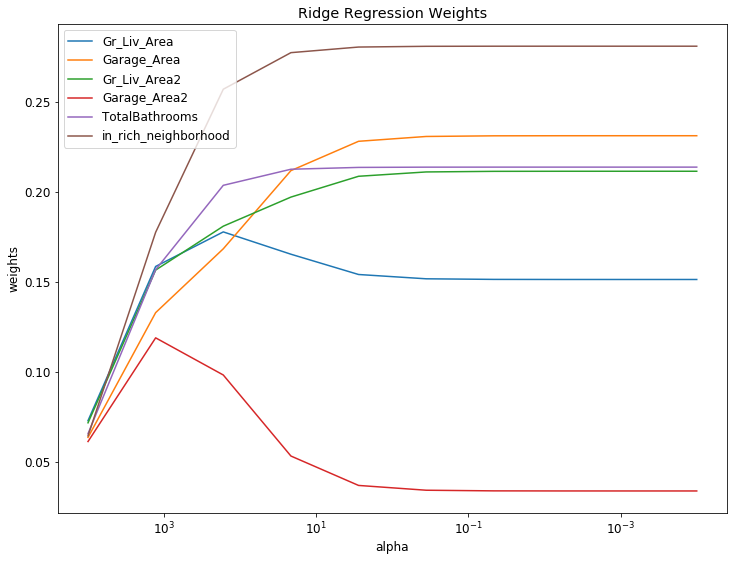

In [29]:
labels = ['Gr_Liv_Area', 
          'Garage_Area', 
          'Gr_Liv_Area2', 
          'Garage_Area2',
          'TotalBathrooms',
          'in_rich_neighborhood'
         ]

coefs = []
for alpha, model in models.items():
    coefs.append(model.coef_)
    
coefs = zip(*coefs)

fig, ax = plt.subplots(ncols = 1, nrows = 1)

for coef, label in zip(coefs, labels): 
    plt.plot(alphas, coef, label = label)
    
ax.set_xscale('log')
#reverse axis
ax.set_xlim(ax.get_xlim()[::-1])
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge Regression Weights')
plt.legend()
plt.savefig('reg_path.png')

# Evaluating the Model

Measure the quality of the model by calculating Root-Mean-Square Error(RMSE) between the predicted house prices and the true prices stored in the SalePrice

In [30]:
def rmse(actual, predicted): 
    """
    Calculates RMSE from actual and predicted values 
    Input:
        actual(1D array) : vector of actual values
        predicted(1D array): vector of predicted/fitted values 
    Output:
        a flout, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

For each alpha, use rmse to calculate the training error and validating error. 

In [31]:
rmse_training = dict()
rmse_validating = dict()

for alpha, model in models.items():
    models[alpha].fit(X_train, y_train)
    Y_train_predict = models[alpha].predict(X_test)
    rmse_training[alpha] = (rmse(y_test,Y_train_predict))
    models[alpha].fit(X_validate, y_validate)
    Y_validate_predict = models[alpha].predict(X_test)
    rmse_validating[alpha] = (rmse(y_test, Y_validate_predict))
    
rmse_training = sorted(rmse_training.items(), key = lambda k: k[1])
rmse_validating = sorted(rmse_validating.items(), key = lambda k: k[1])


In [32]:
alpha_training_min = np.min(rmse_training)
print(alpha_training_min)


0.0001


In [33]:
alpha_validating_min = np.min(rmse_validating)
print(alpha_validating_min)

0.0001


Use the alpha I found, I tried to predict the housing price. 

In [34]:
y_predict = models[alpha_validating_min].predict(X_test)


In [35]:
training_error = rmse(y_train, models[alpha_training_min].predict(X_train))
validating_error = rmse(y_validate, models[alpha_training_min].predict(X_validate))
test_error = rmse(y_test, models[alpha_training_min].predict(X_test))

In [36]:
print("training error:" , training_error)
print("validating error:" , validating_error)
print("test error:" , test_error)



training error: 0.5264391328796195
validating error: 0.472626823423345
test error: 0.5377509720812831


The test error is not significanly larger than the training error. Thus, the model is neither overfitting nor underfitting. 

To see how the model predict the housing prices, I made a residual plot. 

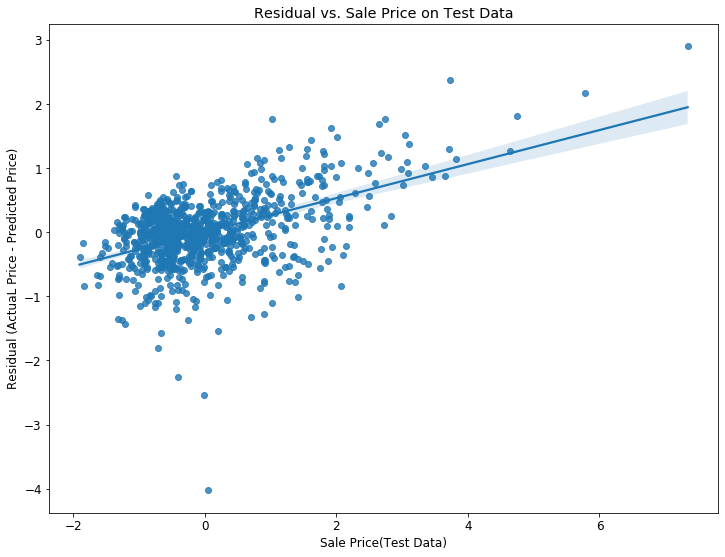

In [37]:
residuals = y_test - y_predict 
ax = sns.regplot(y_test, residuals)
ax.set_xlabel('Sale Price(Test Data)')
ax.set_ylabel('Residual (ActuaL Price - Predicted Price)')
ax.set_title('Residual vs. Sale Price on Test Data')
plt.savefig('residuals.png')